# CNN, пытающая распознать, что из списка на картинке:
- кот
- гепард
- леопард

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("used:", device, "-", torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'cpu')

TRANSFORM = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

C:\Users\k1221\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


used: cuda - NVIDIA GeForce RTX 2070


### Датасет

In [2]:
import os
from PIL import Image
import random

np.random.seed(61112)

class Felidae(torch.utils.data.Dataset):
    '''
    Датасет кошачьих: коты обыкновенные, гепарды, леопарды
    '''
    def __init__(self, data: list = None):
        self.labels = {}
        self._allset = []
        self._allset_tens = []
    
        if data is not None:   # for train, test
            self._allset = data
            random.shuffle(self._allset)
            for path in self._allset:
                if path.find("/cat/") != -1:
                    self.labels[path] = "cat"
                elif path.find("/cheetah/") != -1:
                    self.labels[path] = "cheetah"
                else:
                    self.labels[path] = "leopard"
                
                image = Image.open(path)
                img_tensor = TRANSFORM(image)
                self._allset_tens.append(img_tensor)
    
        else:
            full_path = "./photos/cat/"
            self._cat_paths = [full_path+path for path in os.listdir(full_path)]
            for cat in self._cat_paths:
                self.labels[cat] = "cat"
                self._allset.append(cat)

            full_path = "./photos/cheetah/"
            self._cheetah_paths = [full_path+path for path in os.listdir(full_path)]
            for cheetah in self._cheetah_paths:
                self.labels[cheetah] = "cheetah"
                self._allset.append(cheetah)

            full_path = "./photos/leopard/"
            self._leopard_paths = [full_path+path for path in os.listdir(full_path)]
            for leopard in self._leopard_paths:
                self.labels[leopard] = "leopard"
                self._allset.append(leopard)
                
            random.shuffle(self._allset)
            for path in self._allset:
                image = Image.open(path)
                img_tensor = TRANSFORM(image)
                self._allset_tens.append(img_tensor)

    def split(self):
        border = int(0.75*len(self._allset)+0.5) # 75%
        train = Felidae(self._allset[:border])
        
        test = Felidae(self._allset[border:])
        return (train, test)
    
    def get_lables(self):
        return self.labels
    
    def get_num_of_labels(self):
        num_of_labels = {
            "cat": 0,
            "cheetah": 0,
            "leopard": 0
        }
        
        for animal in self.labels.values():
            num_of_labels[animal] += 1
            
        return num_of_labels
    
    @classmethod
    def get_lables_tensor(cls, labels: list):
        classes = ("cat", "cheetah", "leopard")
        out = []
        for label in labels:
            out.append(classes.index(label))
            
        return torch.LongTensor(out)
    
    @classmethod
    def get_lables_from_tensors(cls, tensors: list):
        classes = ("cat", "cheetah", "leopard")
        out = []
        for tensor in tensors:
            out.append(classes[tensor])
            
        return out
    
    @classmethod
    def img_to_tensor(cls, img):
        trans = transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        img_tensor = trans(img)
        return img_tensor
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self._allset[idx]
        #image = Image.open(img_path)
        #img_tensor = TRANSFORM(image)
        img_tensor = self._allset_tens[idx]
        #label = self.labels[img_path]
        label = Felidae.get_lables_tensor([self.labels[img_path]])[0]
        return img_tensor, label

In [3]:
ds = Felidae()

In [4]:
#Split dataset to train, test
train_ds, test_ds = ds.split()

In [5]:
print(f"train ds len: {len(train_ds)}")
print(train_ds.get_num_of_labels())

print(f"test ds len: {len(test_ds)}")
print(test_ds.get_num_of_labels())

train_ds[0][0].shape

train ds len: 2756
{'cat': 948, 'cheetah': 985, 'leopard': 823}
test ds len: 918
{'cat': 315, 'cheetah': 324, 'leopard': 279}


torch.Size([3, 224, 224])

In [6]:
batch_size = 32
num_workers = 0

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)

classes = ("cat", "cheetah", "leopard")

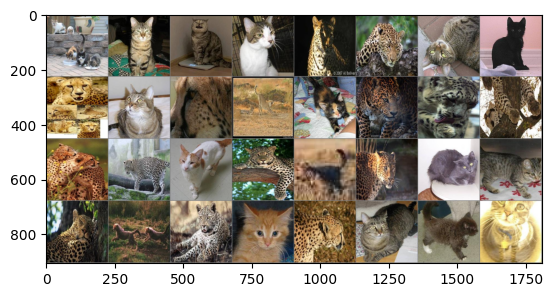

cat cat cat cat leopard leopard cat cat cheetah cat cheetah cheetah cat leopard leopard leopard cheetah leopard cat leopard cheetah leopard cat cat leopard cheetah leopard cat cheetah cat cat cat


In [7]:
# функция для показа изображения
def imshow(img):
    img = img  / 2  + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# получаем несколько случайных обучающих изображений
dataiter = iter(trainloader)
images, labels = next(dataiter)

# показать изображения
imshow(torchvision.utils.make_grid(images))
# показать лейблы изображений
print(' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

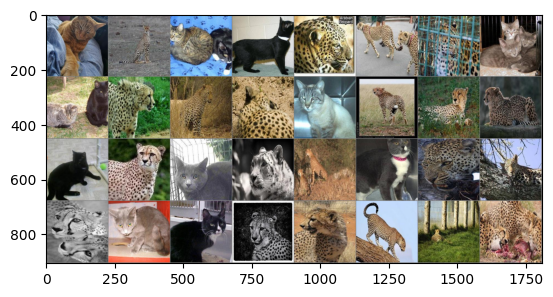

cat cheetah cat cat leopard cheetah leopard cat cat cheetah leopard cheetah cat cheetah cheetah cheetah cat cheetah cat leopard cheetah cat leopard leopard cheetah cat cat cheetah cheetah leopard cheetah cheetah


In [8]:
# получаем несколько случайных тестовых изображений
dataiter = iter(testloader)
images, labels = next(dataiter)

# показать изображения
imshow(torchvision.utils.make_grid(images))
# показать лейблы изображений
print(' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

# Свои архитектуры

In [9]:
# Пока без ReLu
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 96).to(device) # in, out, size
        # out_shape = (in_shape + 2*padding - dilation[def. 1]*(kernel_size-1) - 1)
        #             -------------------------------------------------------------  + 1
        #                                        stride
        # out = 224 + 2*0 - 1*(96-1) - 1 = 129
        
        self.pool1 = nn.MaxPool2d(4, 4).to(device) # (kernel_size, stride). Out_shape = in_shape // kernel_size = 32
        self.conv2 = nn.Conv2d(6, 16, 17).to(device) # Out_shape = 32 - 16 = 16
        self.pool2 = nn.MaxPool2d(4, 4).to(device) # (kernel_size, stride). Out_shape = 4
        
        self.fc1 = nn.Linear(16*4*4, 500).to(device)
        self.fc2 = nn.Linear(500, 60).to(device)
        self.fc3 = nn.Linear(60, 3).to(device)

    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = torch.sigmoid(x)
        x = self.pool1(x)
        #print(x.shape)
        
        x = self.conv2(x)
        #print(x.shape)
        x = torch.sigmoid(x)
        x = self.pool2(x)
        #print(x.shape)
        
        x = x.view(x.size(0),-1)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def __str__(self):
        return "Net1"

net1 = Net1()

### Net2
Net1 но с заменой функции активации сигмоиды на ReLu

In [10]:
# Net1, but sigmoid -> ReLu
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 96).to(device) # in, out, size
        # out_shape = (in_shape + 2*padding - dilation[def. 1]*(kernel_size-1) - 1)
        #             -------------------------------------------------------------  + 1
        #                                        stride
        # out = 224 + 2*0 - 1*(96-1) - 1 = 129
        
        self.pool1 = nn.MaxPool2d(4, 4).to(device) # (kernel_size, stride). Out_shape = in_shape // kernel_size = 32
        self.conv2 = nn.Conv2d(6, 16, 17).to(device) # Out_shape = 32 - 16 = 16
        self.pool2 = nn.MaxPool2d(4, 4).to(device) # (kernel_size, stride). Out_shape = 4
        
        self.fc1 = nn.Linear(16*4*4, 500).to(device)
        self.fc2 = nn.Linear(500, 60).to(device)
        self.fc3 = nn.Linear(60, 3).to(device)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def __str__(self):
        return "Net2"

net2 = Net2()

### Net3
Добавление дропаутов к net2

In [11]:
# Net2, but with dropout
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 96).to(device) # in, out, size
        # out_shape = (in_shape + 2*padding - dilation[def. 1]*(kernel_size-1) - 1)
        #             -------------------------------------------------------------  + 1
        #                                        stride
        # out = 224 + 2*0 - 1*(96-1) - 1 = 129
        
        self.pool1 = nn.MaxPool2d(4, 4).to(device) # (kernel_size, stride). Out_shape = in_shape // kernel_size = 32
        self.drop1 = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(6, 16, 17).to(device) # Out_shape = 32 - 16 = 16
        self.pool2 = nn.MaxPool2d(4, 4).to(device) # (kernel_size, stride). Out_shape = 4
        self.drop2 = nn.Dropout(p=0.3)
        
        self.fc1 = nn.Linear(16*4*4, 500).to(device)
        self.fc2 = nn.Linear(500, 60).to(device)
        self.fc3 = nn.Linear(60, 3).to(device)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.drop1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.drop2(x)
        
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def __str__(self):
        return "Net3"

net3 = Net3()

#### Net4

In [12]:
class Net4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 15, 5).to(device) # in, out, size
        # out_shape = (in_shape + 2*padding - dilation[def. 1]*(kernel_size-1) - 1)
        #             -------------------------------------------------------------  + 1
        #                                        stride
        # out = 224 + 2*0 - 1*(25-1) - 1 = 220
        self.pool1 = nn.MaxPool2d(2, 2).to(device) # 110
        self.conv2 = nn.Conv2d(15, 30, 6).to(device) # 105
        self.drop2 = nn.Dropout(p=0.5)
        
        self.conv3 = nn.Conv2d(30, 60, 16).to(device) # 90
        self.pool3 = nn.AvgPool2d(2, 2).to(device) # 45
        self.drop3 = nn.Dropout(p=0.5)
        
        self.conv4 = nn.Conv2d(60, 120, 26).to(device) # 20
        self.pool4 = nn.MaxPool2d(2, 2).to(device) # 10
        
        self.fc1 = nn.Linear(120*10*10, 403).to(device)
        self.fc2 = nn.Linear(403, 3).to(device)        

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.drop2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.drop3(x)
        
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool4(x)
        
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x
    
    def __str__(self):
        return "Net4"

net4 = Net4()

### Учим сети

In [13]:
from torch.optim import Adam
models = [net1, net2, net3, net4]
best_models = []
criterion = nn.CrossEntropyLoss()

# Hyper-parameters 
num_epochs = 15
learning_rate = 0.001
weight_decay = 0.002 # L2 penalty
losses = {str(model): [] for model in models}

# Сделать чек, что лосс особо не меняется (например, через 2 эпохи разница не более 0.2)
# Хранить лучшую модель за все эпохи (лосс меньше всех)
#delta = 0.2

for net_num, model in enumerate(models):
    model = model.to(device)
    best_model = None
    best_loss = 99999999999999.9
    best_epoch = -1

    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i, (images, labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # обнуляем градиенты параметров
            
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            #if (i+1) % (n_total_steps//2) == 0:
            #    print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {total_loss:.4f}')
            #    losses[model].append(total_loss)
            #    total_loss = 0.0
        
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        losses[str(model)].append(epoch_loss)
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model = model.state_dict()
            best_epoch = epoch
        '''
        if epoch > 1:
            prev2_loss = losses[model][-3]
            
            print(best_loss, epoch_loss, prev2_loss)
            print(prev2_loss - epoch_loss)
            if (epoch_loss - prev2_loss) > delta:
                print("Low loss diff! Stopping...")
                break
        ''' 

    best_models.append(best_model)
    print(f'Finished Training {model}. Best epoch: {best_epoch+1}\n')

Epoch [1/15], Loss: 93.1377
Epoch [2/15], Loss: 87.9804
Epoch [3/15], Loss: 87.0427
Epoch [4/15], Loss: 86.6526
Epoch [5/15], Loss: 86.1618
Epoch [6/15], Loss: 85.0065
Epoch [7/15], Loss: 85.0914
Epoch [8/15], Loss: 84.4894
Epoch [9/15], Loss: 83.9458
Epoch [10/15], Loss: 83.9567
Epoch [11/15], Loss: 83.2440
Epoch [12/15], Loss: 83.4695
Epoch [13/15], Loss: 83.5519
Epoch [14/15], Loss: 82.6296
Epoch [15/15], Loss: 83.1341
Finished Training Net1. Best epoch: 14

Epoch [1/15], Loss: 94.3094
Epoch [2/15], Loss: 88.8313
Epoch [3/15], Loss: 84.1919
Epoch [4/15], Loss: 80.1207
Epoch [5/15], Loss: 79.7716
Epoch [6/15], Loss: 78.1391
Epoch [7/15], Loss: 77.8194
Epoch [8/15], Loss: 76.5742
Epoch [9/15], Loss: 75.3635
Epoch [10/15], Loss: 75.2573
Epoch [11/15], Loss: 74.7411
Epoch [12/15], Loss: 74.2685
Epoch [13/15], Loss: 72.2097
Epoch [14/15], Loss: 73.2312
Epoch [15/15], Loss: 74.2744
Finished Training Net2. Best epoch: 13

Epoch [1/15], Loss: 91.6113
Epoch [2/15], Loss: 86.2072
Epoch [3/15]

### Сохранение сетей на диск

In [39]:
#for i, model in enumerate(models):
for i, model_state in enumerate(best_models):
    PATH = f'./net{i+1}.pth'
    torch.save(model_state, PATH)

### Загрузка сетей с диска

In [43]:
net1, net2, net3, net4 = Net1(), Net2(), Net3(), Net4()
models = [net1, net2, net3, net4]
for i, model in enumerate(models):
    PATH = f'./net{i+1}.pth'
    model.load_state_dict(torch.load(PATH))
    model.eval()

## Проверяем точность сетей

In [44]:
animals_in_test = test_ds.get_num_of_labels()
cats_in_test = animals_in_test["cat"]
cheetahs_in_test = animals_in_test["cheetah"]
leopards_in_test = animals_in_test["leopard"]
for i, model in enumerate(models):
    correct = 0
    total = 0
    correct_class = [0, 0, 0]
    # поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # рассчитываем выходные данные, пропуская изображения через сеть
            outputs = model(images)
            # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
            #_, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            #correct += (predicted == labels).sum().item()
            for predict, label in zip(outputs, labels):
                predict_num = np.argmax(predict.cpu())
                label = label.item()
                if (predict_num == label):
                    correct_class[predict_num] += 1
                    correct += 1

    print(f'Accuracy of the network on the test images for {model}: {100 * correct // total} %')
    cats_pers = int(correct_class[0] / cats_in_test * 100)
    print(f"Cat: {correct_class[0]}/{cats_in_test}   {cats_pers}%")
    cheetahs_pers = int(correct_class[1] / cheetahs_in_test * 100)
    print(f"Cheetah: {correct_class[1]}/{cheetahs_in_test}   {cheetahs_pers}%")
    leopards_pers = int(correct_class[2] / leopards_in_test * 100)
    print(f"Leopard: {correct_class[2]}/{leopards_in_test}   {leopards_pers}%",end="\n\n")

Accuracy of the network on the test images for Net1: 51 %
Cat: 281/315   89%
Cheetah: 173/324   53%
Leopard: 21/279   7%

Accuracy of the network on the test images for Net2: 53 %
Cat: 253/315   80%
Cheetah: 216/324   66%
Leopard: 24/279   8%

Accuracy of the network on the test images for Net3: 51 %
Cat: 182/315   57%
Cheetah: 269/324   83%
Leopard: 20/279   7%

Accuracy of the network on the test images for Net4: 79 %
Cat: 301/315   95%
Cheetah: 238/324   73%
Leopard: 194/279   69%



# Берем уже готовую сеть... [DenseNet](https://arxiv.org/abs/1611.05431)

In [50]:
from torchvision import models as torchmodels

dense_model = torchmodels.densenet161(weights=torchmodels.DenseNet161_Weights.IMAGENET1K_V1)

In [ ]:
dense_model.classifier.out_features = 3
dense_model = dense_model.to(device)
dense_model.train(True)

dense_model

In [52]:
batch_size = 16 # 32 как-то много памяти хочет
num_workers = 0

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)

classes = ("cat", "cheetah", "leopard")

In [54]:
from torch.optim import Adam
criterion = nn.CrossEntropyLoss()

# Hyper-parameters 
num_epochs = 15
learning_rate = 0.001
losses_dense = []

model = model.to(device)
best_dense_model = None
best_loss = 99999999999999.9
best_epoch = -1

optimizer = Adam(dense_model.classifier.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # обнуляем градиенты параметров

        outputs = dense_model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    losses_dense.append(epoch_loss)
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_dense_model = dense_model.state_dict()
        best_epoch = epoch

print(f'Finished Training DenseNet. Best epoch: {best_epoch+1}')

Epoch [1/15], Loss: 13.4015
Epoch [2/15], Loss: 11.6544
Epoch [3/15], Loss: 10.5886
Epoch [4/15], Loss: 9.6593
Epoch [5/15], Loss: 8.8412
Epoch [6/15], Loss: 8.1175
Epoch [7/15], Loss: 7.4796
Epoch [8/15], Loss: 6.9167
Epoch [9/15], Loss: 6.4162
Epoch [10/15], Loss: 5.9687
Epoch [11/15], Loss: 5.5681
Epoch [12/15], Loss: 5.2094
Epoch [13/15], Loss: 4.8877
Epoch [14/15], Loss: 4.5984
Epoch [15/15], Loss: 4.3381
Finished Training DenseNet. Best epoch: 15


### Проверим точность

In [55]:
animals_in_test = test_ds.get_num_of_labels()
cats_in_test = animals_in_test["cat"]
cheetahs_in_test = animals_in_test["cheetah"]
leopards_in_test = animals_in_test["leopard"]

correct = 0
total = 0
correct_class = [0, 0, 0]
# поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # рассчитываем выходные данные, пропуская изображения через сеть
        outputs = dense_model(images)
        # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
        #_, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        #correct += (predicted == labels).sum().item()
        for predict, label in zip(outputs, labels):
            predict_num = np.argmax(predict.cpu())
            label = label.item()
            if (predict_num == label):
                correct_class[predict_num] += 1
                correct += 1

print(f'Accuracy of the network on the test images for DenseNet: {100 * correct // total} %')
cats_pers = int(correct_class[0] / cats_in_test * 100)
print(f"Cat: {correct_class[0]}/{cats_in_test}   {cats_pers}%")
cheetahs_pers = int(correct_class[1] / cheetahs_in_test * 100)
print(f"Cheetah: {correct_class[1]}/{cheetahs_in_test}   {cheetahs_pers}%")
leopards_pers = int(correct_class[2] / leopards_in_test * 100)
print(f"Leopard: {correct_class[2]}/{leopards_in_test}   {leopards_pers}%",end="\n\n")

Accuracy of the network on the test images for DenseNet: 94 %
Cat: 305/315   96%
Cheetah: 312/324   96%
Leopard: 246/279   88%



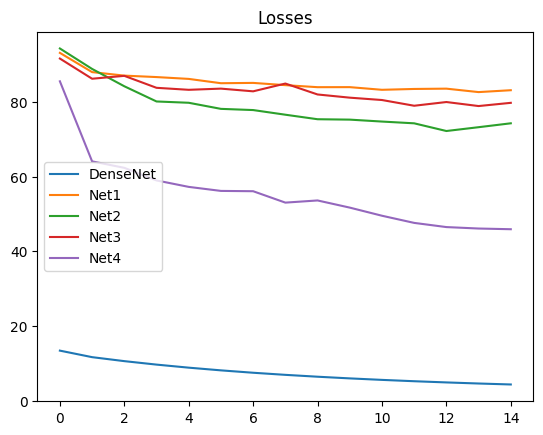

In [56]:
plt.plot(losses_dense, label="DenseNet")
plt.plot(losses["Net1"], label="Net1")
plt.plot(losses["Net2"], label="Net2")
plt.plot(losses["Net3"], label="Net3")
plt.plot(losses["Net4"], label="Net4")
plt.legend()
plt.title("Losses")
plt.show()
plt.close()

### Сохранить/загрузить сеть

In [58]:
PATH = f'./dense.pth'
save = False
if save:
    torch.save(best_dense_model, PATH)
else:
    dense_model.load_state_dict(torch.load(PATH))
    dense_model.eval()

In [60]:
models.append(dense_model)

# Проверка сетей на Вашей картинке

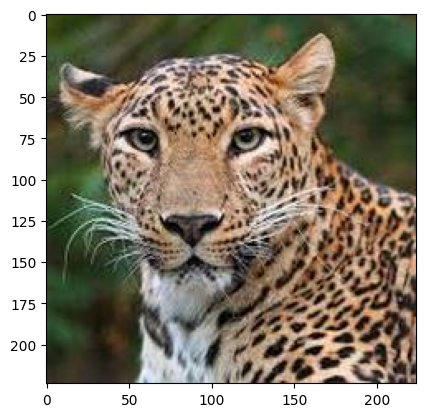

Net1 says: it is cheetah
Net2 says: it is cheetah
Net3 says: it is cheetah
Net4 says: it is leopard
DenseNet says: it is leopard


In [61]:
from PIL import Image
import requests
from io import BytesIO
from resizeimage import resizeimage

#cats
#url = "https://sun9-9.userapi.com/impg/aHf1volSMaQAgwl9C9jo9MU101QhuTSMFKx24Q/2U54RbtADxY.jpg?size=476x607&quality=96&sign=c8753183c7d69a066622993d76665072&type=album"
#url = "https://sun9-80.userapi.com/impg/PmNo8Akj4bJNV12y655oW8j76kxS26_hCpsmEg/bm6DbL7rl4c.jpg?size=810x1080&quality=95&sign=b084c0fba51e0fd65f81abce4873d71a&type=album"
#url = "https://sun9-78.userapi.com/impg/iMYc9Gj7h7kBrQsVneEJNpmSOZJdMsbE-ucPpQ/yoMtCmiCRIc.jpg?size=1280x960&quality=95&sign=2631bbf27d6931a24283efd85ebfbbdd&type=album"
#чудик рыжий
#url = "https://cojo.ru/wp-content/uploads/2022/12/poroda-uralskii-reks-2.webp"

#Cheetah
#url = "https://theanimalw.com/wp-content/uploads/2016/03/416.jpg"
#url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQhMnI6T2u0s_lrlCVZyEKSjnng5phntkQM4g&usqp=CAU"

#leopard
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSGduTZvVNSxX53RU5ErIjmnqEVeAAUC4hTzQ&usqp=CAU"
#url = "https://thumbs.dreamstime.com/z/%D0%BB%D0%B5%D0%BE%D0%BF%D0%B0%D1%80%D0%B4-29429480.jpg"
#url = "https://shimmercat.abicart.se/shop/images/31133043-origpic-4b624e/26809/art9/h3043/11266689_zoom_can.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = resizeimage.resize_cover(img, [224, 224])
path = "./check/cat/1.jpg"
img.save(path)

check_ds = Felidae([path])
checkloader = torch.utils.data.DataLoader(check_ds, batch_size=1, num_workers=num_workers)

classes = ("cat", "cheetah", "leopard")

image, label = next(iter(checkloader))
imshow(torchvision.utils.make_grid(image.cpu()))

for model in models:
    with torch.no_grad():
        #for data in checkloader:
        image, label = image.to(device), label.to(device)
        # рассчитываем выходные данные, пропуская изображения через сеть
        output = model(image)

        predict_num = np.argmax(output.cpu())
        print(f"{model.__class__.__name__} says: it is {classes[predict_num]}")